<a href="https://colab.research.google.com/github/PiasTanmoy/EEG-DEAP-1D-CNN/blob/main/Deap_EEG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-3t4sgx7o
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-3t4sgx7o
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28122 sha256=1df7efcf6d32ddd892b8e0f15bbcb41e9b2fc6bf0c2db1cf1cd3c8d4ce386f85
  Stored in directory: /tmp/pip-ephem-wheel-cache-t217q6q_/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [ ]:
#git clone https://github.com/forrestbao/pyeeg.git

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyeeg

ERROR: Could not find a version that satisfies the requirement pyeeg (from versions: none)
ERROR: No matching distribution found for pyeeg


In [3]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
#import tensorflow as tf
import time

In [4]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects
path_to_dataset = '/content/drive/My Drive/Datasets/DEAP-dataset/data_preprocessed_python/'

In [15]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        #np.save('C:/Users/faizan/Downloads/data_preprocessed_python/data_preprocessed_python/s' + sub, meta, allow_pickle=True, fix_imports=True)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True)


In [16]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [10]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [7]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file:
        sub = np.load(file)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
          

In [8]:
# restore np.load for future normal usage
np.load = np_load_old

In [9]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (51240, 70) (51240, 4)
testing dataset: (7320, 70) (7320, 4)


In [11]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [12]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')


In [13]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
x_train = np.array(X[:])

In [15]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [16]:
x_test = np.array(M[:])

In [17]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [19]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [20]:
x_train.shape

(51240, 70, 1)

In [34]:
batch_size = 256
num_classes = 10
epochs = 100
input_shape=(x_train.shape[1], 1)

In [24]:
print(input_shape)

(70, 1)


In [25]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [38]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_3 (Batch (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)             

In [39]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
H = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/100
201/201 [==============================] - 1s 7ms/step - loss: 1.9668 - accuracy: 0.2743
Epoch 2/100
201/201 [==============================] - 1s 7ms/step - loss: 1.7618 - accuracy: 0.3315
Epoch 3/100
201/201 [==============================] - 1s 7ms/step - loss: 1.6501 - accuracy: 0.3774
Epoch 4/100
201/201 [==============================] - 1s 7ms/step - loss: 1.5789 - accuracy: 0.4062
Epoch 5/100
201/201 [==============================] - 1s 7ms/step - loss: 1.5190 - accuracy: 0.4292
Epoch 6/100
201/201 [==============================] - 1s 7ms/step - loss: 1.4677 - accuracy: 0.4533
Epoch 7/100
201/201 [==============================] - 1s 7ms/step - loss: 1.4237 - accuracy: 0.4688
Epoch 8/100
201/201 [==============================] - 1s 7ms/step - loss: 1.3844 - accuracy: 0.4865
Epoch 9/100
201/201 [==============================] - 1s 7ms/step - loss: 1.3533 - accuracy: 0.4976
Epoch 10/100
201/201 [==============================] - 1s 7ms/step - loss: 1.3102 - accura

In [41]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

229/229 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.7572
Test loss: 0.6874601244926453
Test accuracy: 0.7572404146194458


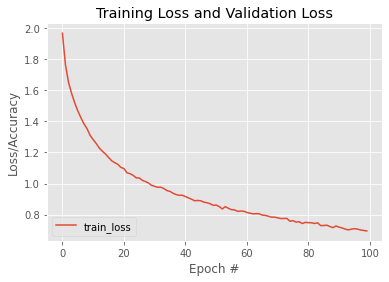

In [44]:
N = num_classes
EPOCS = 100
# construct a plot that plots and saves the training history
import matplotlib.pyplot as plt
N = np.arange(0, EPOCS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#base_path_graphs = '/content/drive/My Drive/Google_Colab/Autoencoder/Graphs/'
#path_loss_acc = base_path_graphs + model_name + 'Train_loss_Val_loss.png'
#plt.savefig(base_path_graphs, dpi=1000, bbox_inches='tight')
#files.download( "Train_Accuracy.png" )

In [47]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 643    1    8    7   19    2    2   17  155]
 [  16  808   32   22    2    8    5    9   74]
 [  51    9 1124   41   19   11   13    8   66]
 [  44    4   15  484   12    3    2   39  129]
 [  49    0   11   10  245    0    1    7  104]
 [  34    4    6    4    2  556    4    7  115]
 [   6   11    8    1    0   16  813   18  225]
 [  21    2    2    7    9    1    5  421  203]
 [  15    0    1    1    0    1    4   17  449]]
Normalized confusion matrix
[[7.53e-01 1.17e-03 9.37e-03 8.20e-03 2.22e-02 2.34e-03 2.34e-03 1.99e-02
  1.81e-01]
 [1.64e-02 8.28e-01 3.28e-02 2.25e-02 2.05e-03 8.20e-03 5.12e-03 9.22e-03
  7.58e-02]
 [3.80e-02 6.71e-03 8.38e-01 3.06e-02 1.42e-02 8.20e-03 9.69e-03 5.96e-03
  4.92e-02]
 [6.01e-02 5.46e-03 2.05e-02 6.61e-01 1.64e-02 4.10e-03 2.73e-03 5.33e-02
  1.76e-01]
 [1.15e-01 0.00e+00 2.58e-02 2.34e-02 5.74e-01 0.00e+00 2.34e-03 1.64e-02
  2.44e-01]
 [4.64e-02 5.46e-03 8.20e-03 5.46e-03 2.73e-03 7.60e-01 5.46e-03 9.56

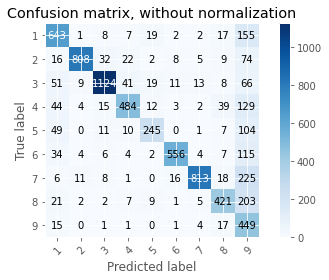

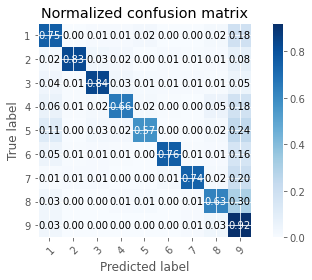

In [48]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Referece (Thanks!)

[Blog](https://medium.com/@Rehan_Sayyad/eeg-signal-classification-using-deep-learning-709ae47c3706)

[Code](https://github.com/Rehan-A/EEG-signal-classification-using-Deep-Learning/blob/master/Deap.ipynb)